In [ ]:
"""
Created on Thu Mar  9 09:02:49 2023

@author: Nicolo' Daina
"""

"\nCreated on Thu Mar  9 09:02:49 2023\n\n@author: Nicolo' Daina\n"

In [ ]:
#%% load packages/libraries
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [ ]:
df1 = pd.read_csv("Quarter 3 filtered data.csv")
df2 = pd.read_csv("Quarter 4 filtered data.csv")
df = pd.concat([df1, df2], axis = 0)

In [ ]:
"""
#%% load data
# read file into pandas dataframe
df = pd.read_csv("Full Transactions.csv")
"""
df.StartDateTime = pd.to_datetime(df.StartDateTime)
df.StopDatetime = pd.to_datetime(df.StopDatetime)

In [ ]:
#%% Select period  and stations of interest (the codes takes a while to run!)

start2018=dt.datetime(2018,7,1) # consider 1 day before the start of the quarter so that station availablity for the first event can be found
start2019=dt.datetime(2019,1,1)

In [ ]:
I1=(df.StartDateTime>=start2018) & (df.StopDatetime<start2019)
I2=df['station_name'].str.startswith('Camden')

In [ ]:
df = df[I1 & I2]

In [ ]:
df=df.reset_index(drop=True)
#%% gegerate time sereis of occupacy/avalaibility for each charging station
# transform event based data into longitudinal connection time data (where the connection time is over period T)
cs = df.station_num_id.unique()

In [ ]:
mindate = min(df.StartDateTime)
maxdate = max(df.StopDatetime)
data = {"StartDateTime": [mindate, maxdate],
        "StopDatetime": [mindate, maxdate]}
dfboundary = pd.DataFrame(data)

In [ ]:
newdf = pd.DataFrame()

check_cp = list()

for st in cs:
    dfst = df[df.station_num_id == st].reset_index()
    fot = min(dfst.StartDateTime)  # first observation time
    lot = max(dfst.StopDatetime)  # last observation time
    nb_chargepoints = dfst.nb_chargepoints[0]
    stat_id = dfst.station_dsp_id[0]
    stat_name = dfst.station_name[0]


    # ensure that we have the same number of records for all stations
    dfst = dfst.append(dfboundary)

    # counts the number of vehicles connected to charging station st in each minute
    enter_count = dfst.StartDateTime.value_counts()
    exit_count = dfst.StopDatetime.value_counts()
    df2 = pd.concat([enter_count, exit_count], axis=1, keys=["enter", "exit"])
    df2.fillna(0, inplace=True)
    df2["diff"] = df2["enter"] - df2["exit"]
    counts = df2["diff"].resample("1min").sum().fillna(0).cumsum()

    # check if in any connection minutes there are more connections than the  number of charging points at a station (a)
    c = counts > nb_chargepoints
    # assume that if there are more connections than charger in any minute it is because one trasasaction is ending
    # in the same minute as another is starting
    counts[c] = nb_chargepoints

    # aggregate in time on a T time period (i.e. calculate connection time over T)
    T = "5min"
    counts = counts.resample(T).sum().fillna(0)
    
    # start time of period
    timestamp = counts.index
    
    # number of vehicle-minutes of connection in a period 
    timeconnected = counts.values
    
    # occupancy of the charging station over a period
    occupancy = np.ceil(timeconnected/5)
    
    # number of charging point available (i.e. not coccupied) at the cgharging station over a period
    availability = nb_chargepoints - occupancy

    data = {"station_id": np.repeat(stat_id, len(timeconnected)),
            "station_num_id":np.repeat(st, len(timeconnected)),
            "station_name":np.repeat(stat_name, len(timeconnected)),
            "ncp": np.repeat(nb_chargepoints, len(timeconnected)),
            "fot": np.repeat(fot, len(timeconnected)),
            "lot": np.repeat(lot, len(timeconnected)),
            "timestamp": timestamp,
            "timeconnected": timeconnected,
            "occupancy":occupancy,
            "av":availability}
    df3 = pd.DataFrame(data)

    # for each station set to NaN timeconnected/occupancy/availablity in in the periods before the first charging event and the last in the record
    df3.loc[(df3.timestamp < fot), 'timeconnected'] = np.NaN
    df3.loc[(df3.timestamp > lot), 'timeconnected'] = np.NaN
    
    df3.loc[(df3.timestamp < fot), 'occupancy'] = np.NaN
    df3.loc[(df3.timestamp > lot), 'occupancy'] = np.NaN
    
    df3.loc[(df3.timestamp < fot), 'av'] = np.NaN
    df3.loc[(df3.timestamp > lot), 'av'] = np.NaN
    newdf = newdf.append(df3)

newdf=newdf.reset_index(drop=True)

<ipython-input-10-6decdea9e4a4>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfst = dfst.append(dfboundary)
<ipython-input-10-6decdea9e4a4>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  newdf = newdf.append(df3)
<ipython-input-10-6decdea9e4a4>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfst = dfst.append(dfboundary)
<ipython-input-10-6decdea9e4a4>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  newdf = newdf.append(df3)
<ipython-input-10-6decdea9e4a4>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfst = dfst.append(dfboundary)


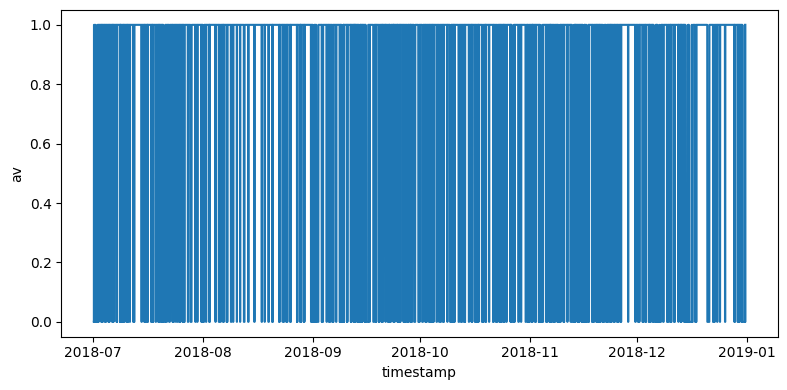

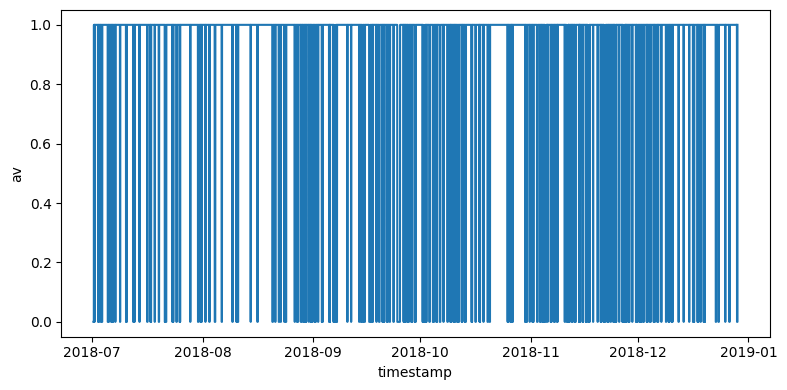

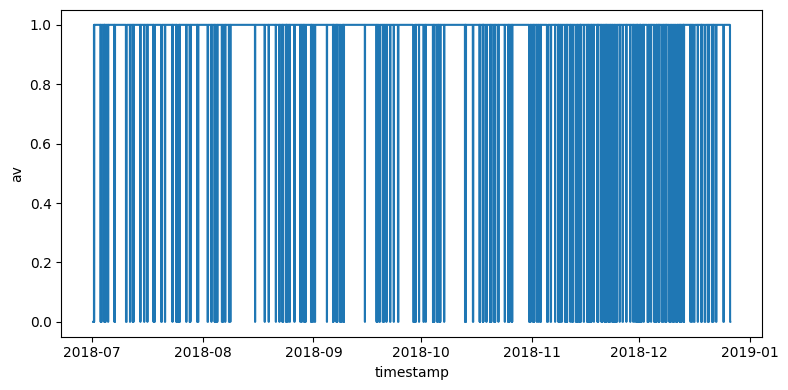

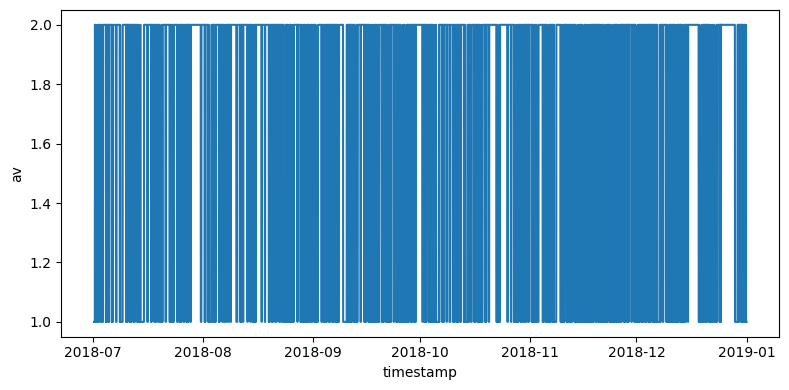

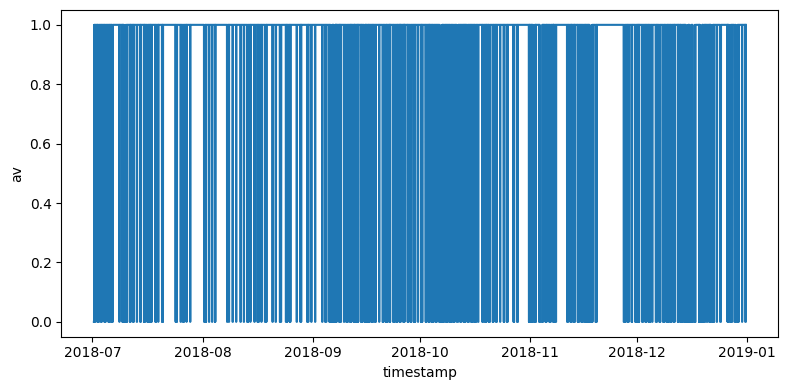

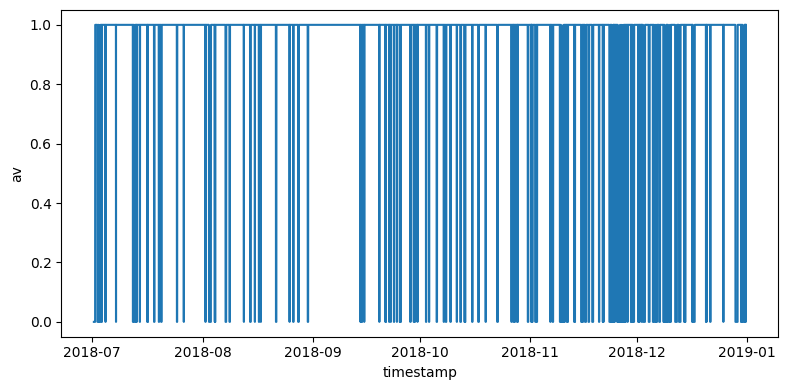

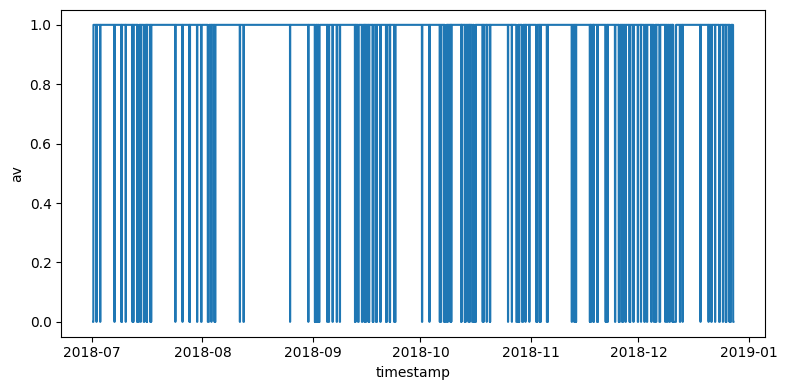

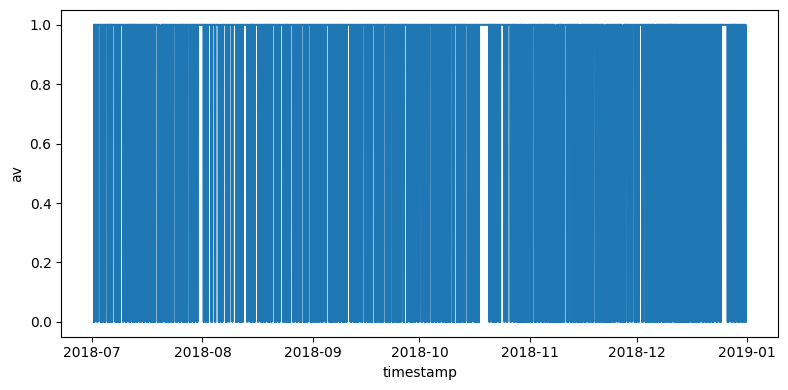

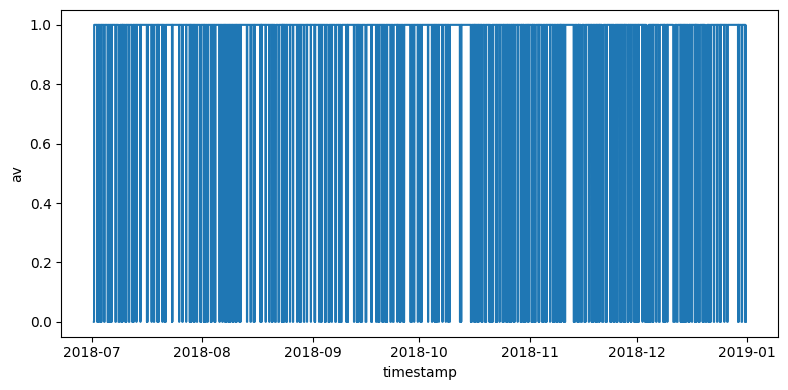

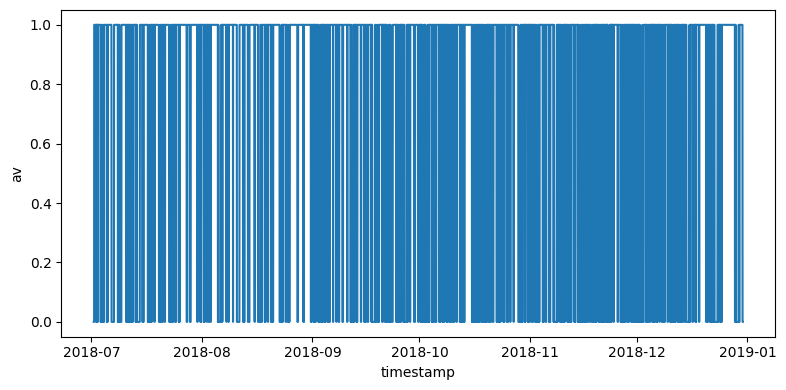

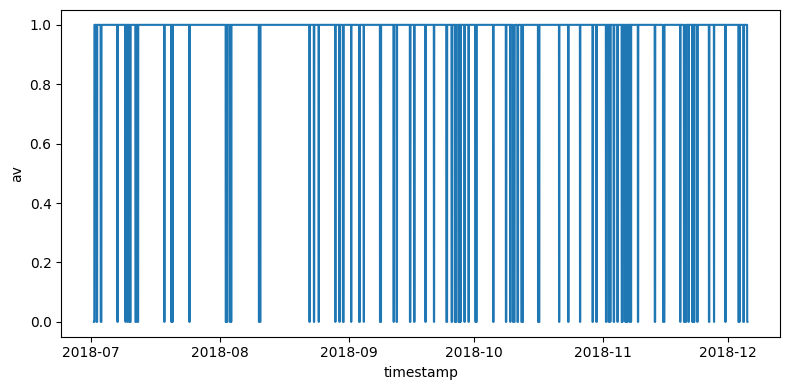

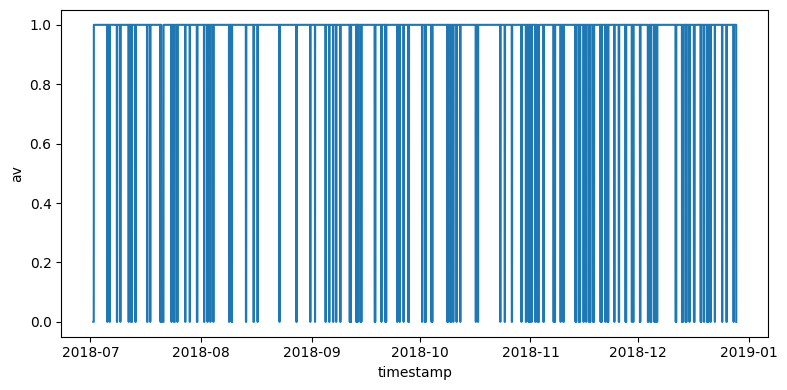

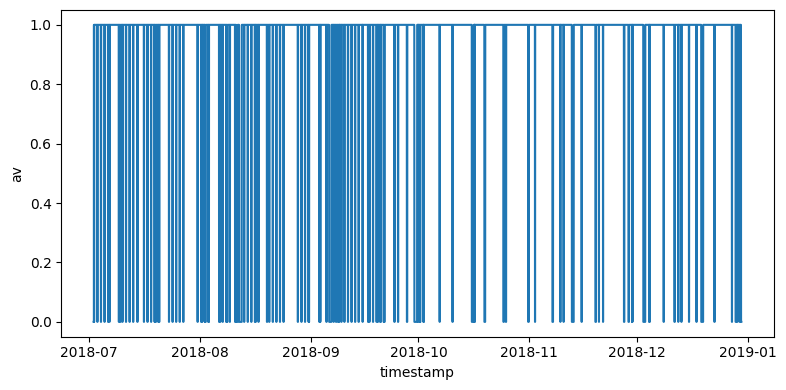

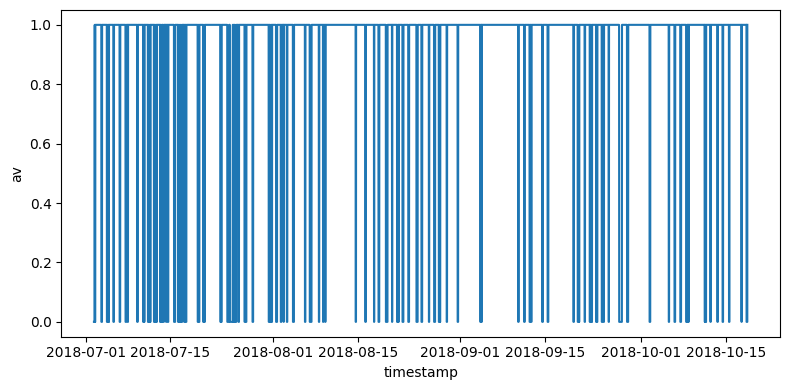

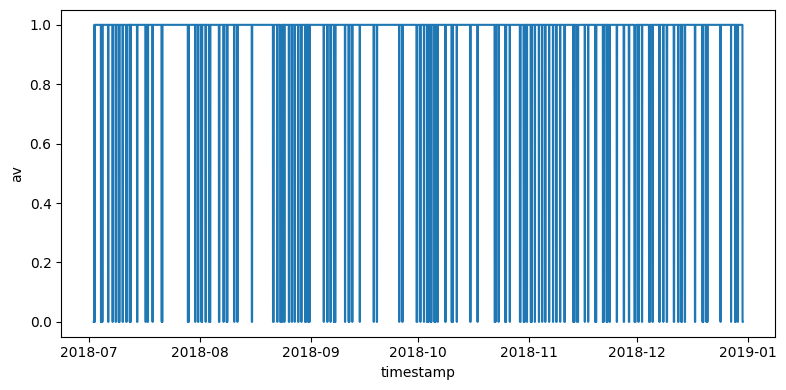

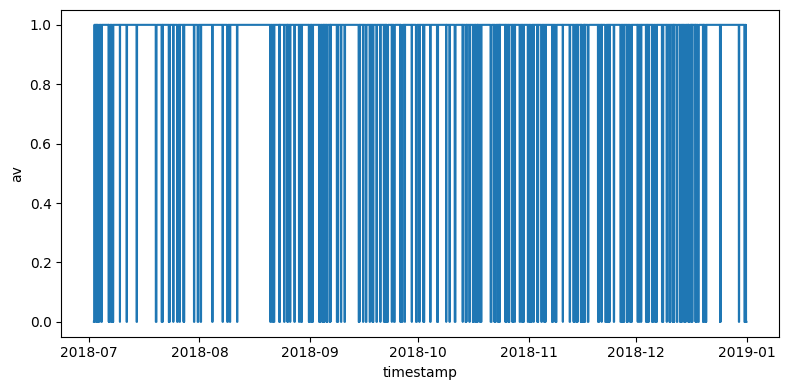

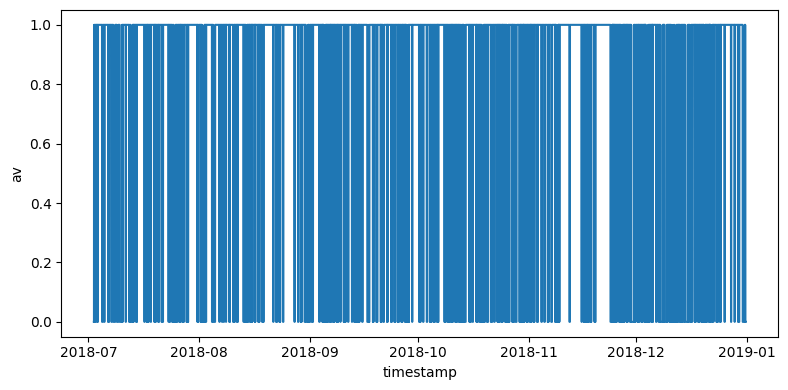

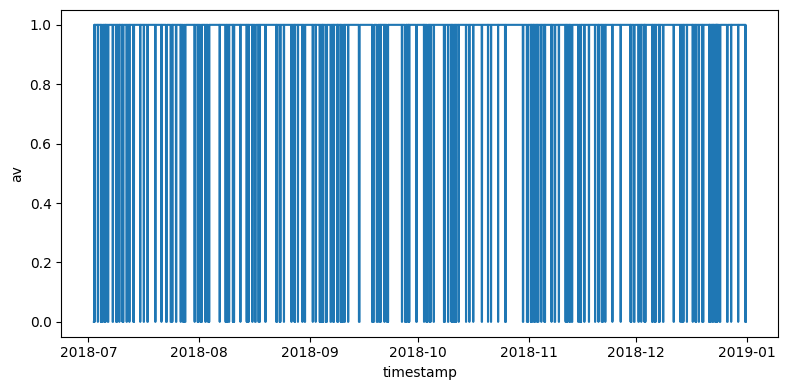

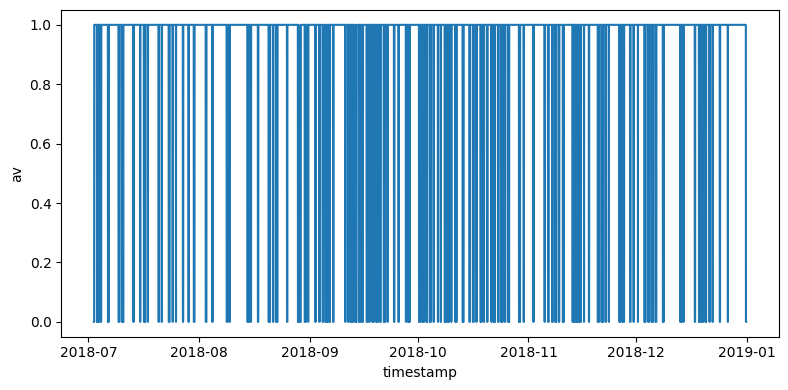

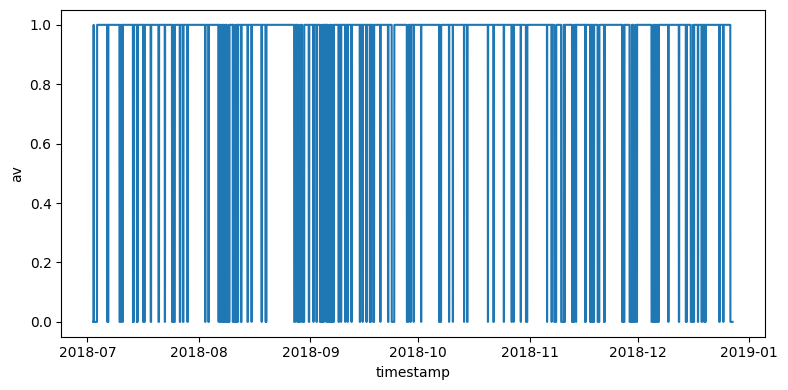

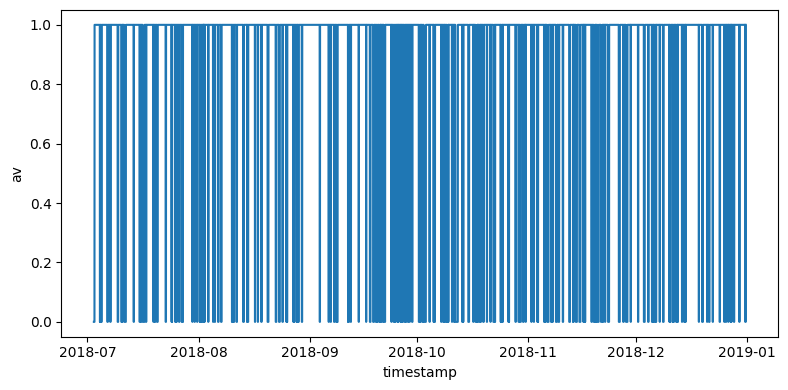

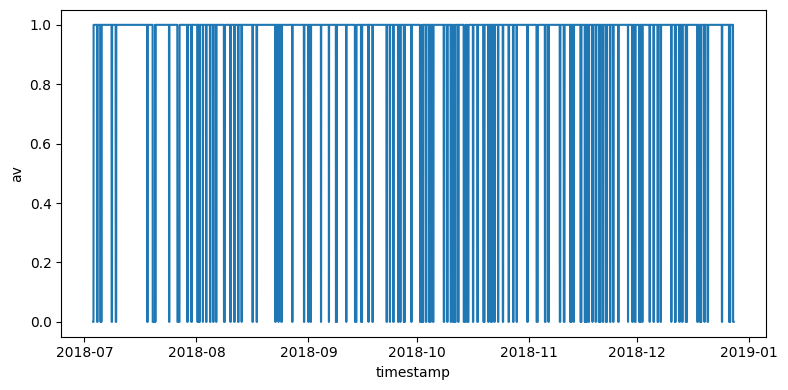

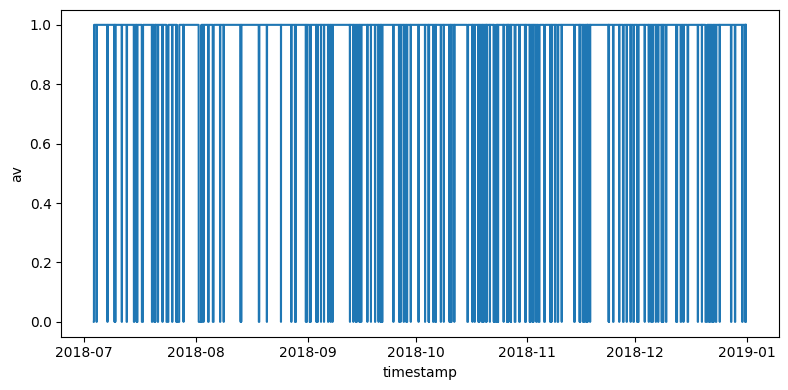

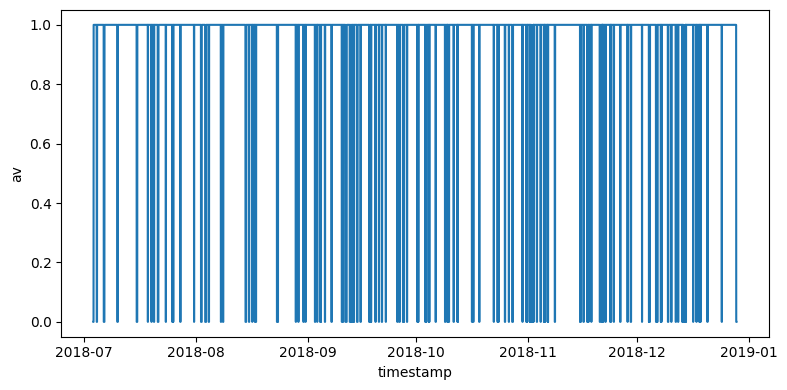

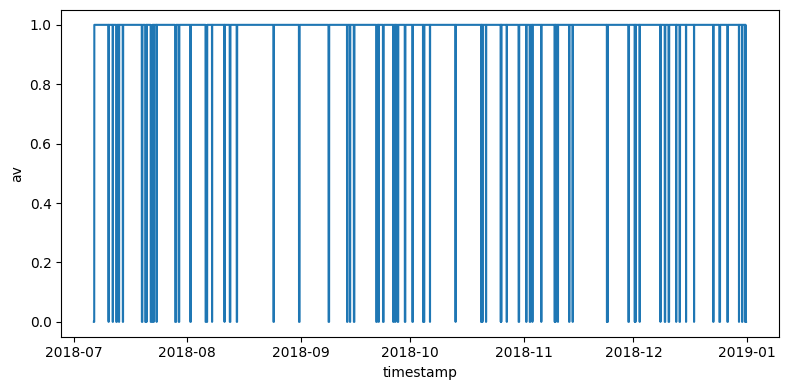

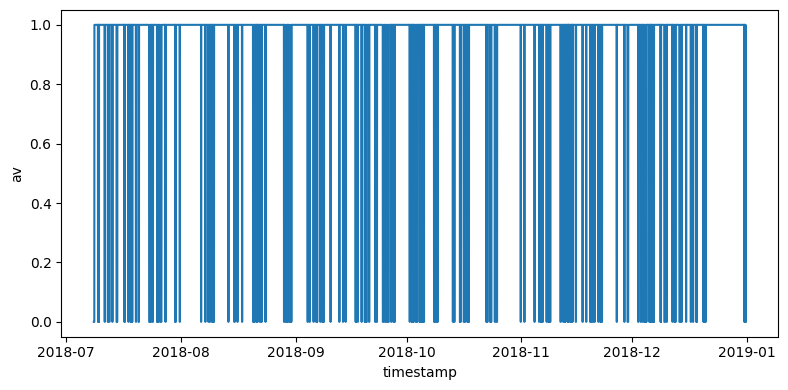

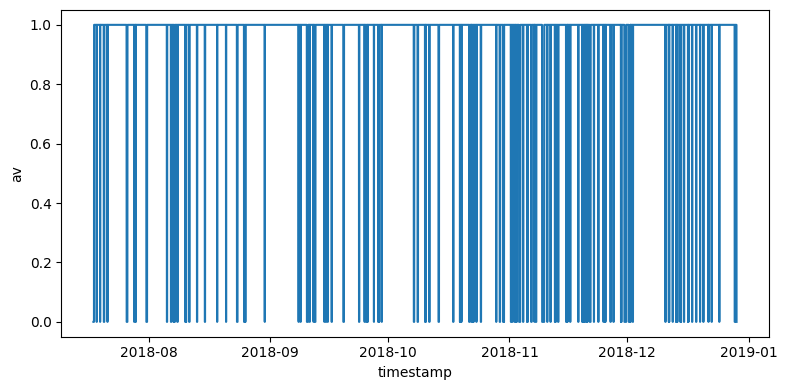

In [ ]:
#%% plot availabilities

for st in cs:
    plt.figure(figsize=(8,4))
    data=newdf[newdf.station_num_id==st]
    sns.lineplot(data=data,x="timestamp",y="av")
    plt.tight_layout()
    plt.show()

In [ ]:
#%% create new df with timestamp and all stations with >=1 cp available available in that timestamp

TT=newdf.timestamp.unique()
query=[]
for t in TT:
    I=(newdf.timestamp==t) & (newdf.av>0)
    a=newdf.station_id[I].tolist()
    query=query+[a]
    
avdf = pd.DataFrame({'timeperiod':TT, 'st_available':query})
avdf=avdf.reset_index(drop=True)

In [ ]:
#%% indentify choice sets for all charging events by availability
# dataframe with choice set considering availability is aaa

df['fiveminperiod_of_Start']=df['StartDateTime'].apply(lambda x: pd.Timestamp(x).floor(freq="5T"))
df['fiveminperiod_before_Start']=df['fiveminperiod_of_Start']-dt.timedelta(minutes=5)

aaa=pd.merge(left=df,
         right=avdf,
         left_on="fiveminperiod_before_Start",
         right_on="timeperiod",
         how="left"
         )

aaa=aaa.reset_index(drop=True)

In [ ]:
# drop events before the begniing of the qquarter tthat were use only to inditify availability of stations
# for the firts event

start2018=dt.datetime(2018,10,1)
start2019=dt.datetime(2019,1,1)

I1=(aaa.StartDateTime>=start2018) & (aaa.StopDatetime<start2019)


aaa=aaa[I1]

aaa=aaa.reset_index(drop=True)

In [ ]:
aaa.to_csv("Availability_Q4.csv")